In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
from sys import exit
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from inference.eval_ import evaluate_all_sets, get_distance

In [3]:
### load embeds ~90GB
embeds = np.load('/home/wes/Data/embeds/wf4m_r100_af_embeds.npy')

In [56]:
sets = glob.glob('validation_sets/race_gender/*/*.list')
# sets = glob.glob('validation_sets/iqa_sets/*/*.list')
sets.sort(key=lambda x: os.path.basename(os.path.dirname(x)), reverse=False)
sets=sets[:1]

In [57]:
len(sets)
# sets

1

In [105]:
del test_embeds

NameError: name 'test_embeds' is not defined

In [58]:
test_idxs = []
test_pairs = []
datasize=20000
for s in sets:
    s = s.replace('.list', '.npy')
    x = np.load(s)
    assert x.shape[0] % 3 == 0
    assert x.shape[0] / 3 == datasize / 2
    pairs = list(x[int(datasize):])
    test_pairs += pairs
    test_idxs.append(x[:int(datasize)])
    
len(test_idxs[0])
len(test_pairs)


test_idxs = np.concatenate(test_idxs)
test_idxs.shape
test_embeds = embeds[test_idxs]
test_embeds.shape

(20000, 512)

In [18]:
x = evaluate_all_sets(test_embeds, test_pairs, sets, num_sets=10, data_size=20000,
                 save_name='test')

black_female                   AVG tar@far 0.990420+/-0.00263 acc 0.996510+/-0.00076
black_male                     AVG tar@far 0.995020+/-0.00170 acc 0.997980+/-0.00031
east_asian_female              AVG tar@far 0.982260+/-0.00584 acc 0.995070+/-0.00069
east_asian_male                AVG tar@far 0.998160+/-0.00116 acc 0.998860+/-0.00045
indian_female                  AVG tar@far 0.989440+/-0.00303 acc 0.996350+/-0.00068
indian_male                    AVG tar@far 0.997580+/-0.00141 acc 0.998630+/-0.00057
latino_hispanic_female         AVG tar@far 0.992720+/-0.00307 acc 0.996920+/-0.00052
latino_hispanic_male           AVG tar@far 0.998480+/-0.00066 acc 0.998980+/-0.00031
middle_eastern_female          AVG tar@far 0.983540+/-0.00433 acc 0.995160+/-0.00056
middle_eastern_male            AVG tar@far 0.996780+/-0.00106 acc 0.998220+/-0.00042
southeast_asian_female         AVG tar@far 0.985140+/-0.00336 acc 0.994760+/-0.00052
southeast_asian_male           AVG tar@far 0.996880+/-0.00100 acc

In [44]:
li = [('race_gender/white_male', 'Caucasian Male'), ('race_gender/black_female', 'Black Female')]
results = []
datasize=20000

number = 3
total = number*10000

mask = np.ones(total, dtype=bool)
pairs_list = np.ones(total*len(li))
for i in range(number):
    mask[5000+(10000*i):10000*(i+1)] = False
    pairs_list[5000+(10000*i):10000*(i+1)] = 0

names = []
atts = []
for idx_, (l, name) in enumerate(li):
    names += [name]*total
    d_sets = glob.glob(os.path.join('validation_sets', l, '*.npy'))[:number]
    for r in d_sets:
        x = np.load(r)
        d_pairs = list(x[int(datasize):])
        idxs = x[:int(datasize)] 
        d_embeds = embeds[idxs]
        results.append(get_distance(d_embeds, d_pairs))
#     results.append(np.concatenate(curr))
    atts.append(np.ones(total)*idx_)
    
print(len(results))
print(results[0].shape)
# exit()
print('names..')
names = np.array(names)
atts = np.concatenate(atts)
results = np.concatenate(results)
print('stack..')
print(results.shape, pairs_list.shape, names.shape)
arr = np.stack((results, pairs_list, atts)).T
print('df..')
df = pd.DataFrame(arr, columns = ['Similarity','Match', 'Attributes'])
# df = pd.DataFrame(arr, columns = ['Similarity','Match'])
del arr, names, pairs_list, curr


tar@far 0.99960 acc 0.99980
tar@far 1.00000 acc 0.99990
tar@far 0.99980 acc 0.99970
tar@far 0.98740 acc 0.99650
tar@far 0.99060 acc 0.99690
tar@far 0.98920 acc 0.99620
6
(10000,)
names..
stack..
(60000,) (60000,) (60000,)
df..


NameError: name 'curr' is not defined

0.49204057
0.49112463


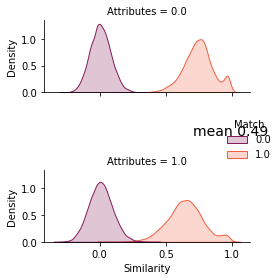

In [53]:
x = results
for i in range(len(li)):
    diff = np.abs(np.mean(x[10000*i:5000+10000*(i+1)]) - np.mean(x[5000+(10000*i):10000*(i+1)]))
    print(diff)
sns.displot(data=df, x='Similarity', hue='Match', col='Attributes', kind='kde',
            fill=True, palette='rocket', col_wrap=1)
fig = plt.gcf()
fig.set_size_inches(4,4)
plt.text(.7, 2, f'mean {diff:.2f}', fontsize=14)
plt.tight_layout(h_pad=0)
plt.show()

In [28]:
df

,Similarity,Match,Attributes
0,0.80336875,1.0,Caucasian Male
1,0.9542838,1.0,Caucasian Male
2,0.65788645,1.0,Caucasian Male
3,0.78616375,1.0,Caucasian Male
4,0.7616137,1.0,Caucasian Male
...,...,...,...
9995,-0.078470916,0.0,Caucasian Male
9996,0.18338531,0.0,Caucasian Male
9997,0.060416244,0.0,Caucasian Male
9998,0.23813118,0.0,Caucasian Male


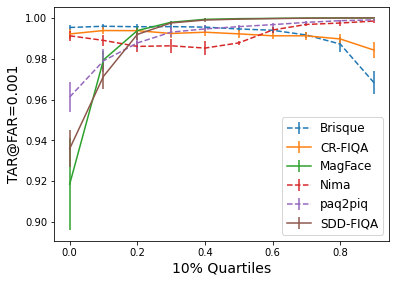

In [93]:
# (name, tar, acc, std, norm)
re = {}
for name,tar,acc,std,norm in x:
    name = name.replace('validation_sets/iqa_sets', '').replace('.list','')
    name = os.path.basename(os.path.dirname(name))
    if name in re.keys():
        re[name].append(tar)
    else:
        re[name] = [tar]
        
re2 = {}
for k,v in re.items():
    name = k[:-7]
    arr = np.array(v)
    q = float(k[-7:-4])
    if name in re2.keys():
        re2[name].append((q,np.mean(v), np.std(v)))
    else:
        re2[name] = [(q,np.mean(v), np.std(v))]
        

    
        
re2['sdd-fiqa']

import matplotlib.pyplot as plt

for k, v in re2.items():
    x_val = [y[0] for y in v]
    y_val = [y[1] for y in v]
    err = [y[2] for y in v]
    if k in ['sdd-fiqa', 'magface', 'cr-fiqa']:
        m = '-'
    else:
        m = '--'
    plt.errorbar(x_val, y_val, err, linestyle=m)

    
keys = ['Brisque', 'CR-FIQA', 'MagFace', 'Nima', 'paq2piq', 'SDD-FIQA']
plt.legend(keys, fontsize=12)

plt.xlabel('10% Quartiles', fontsize=14)
plt.ylabel('TAR@FAR=0.001', fontsize=14)
fig = plt.gcf()
fig.set_size_inches(6,4.3)
# plt.grid()
plt.show()
        